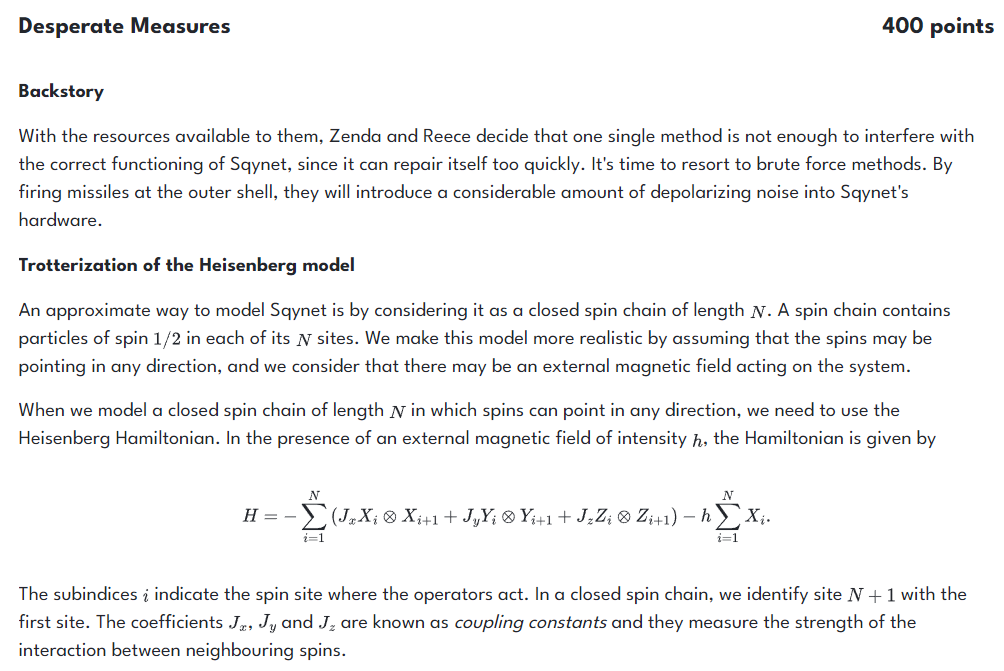

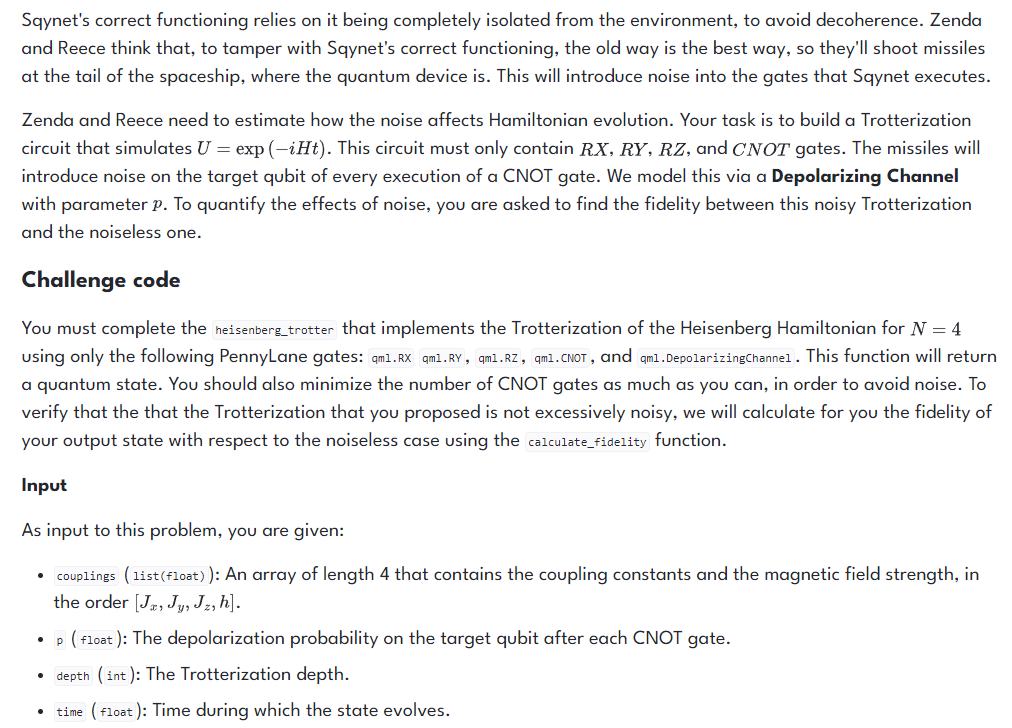

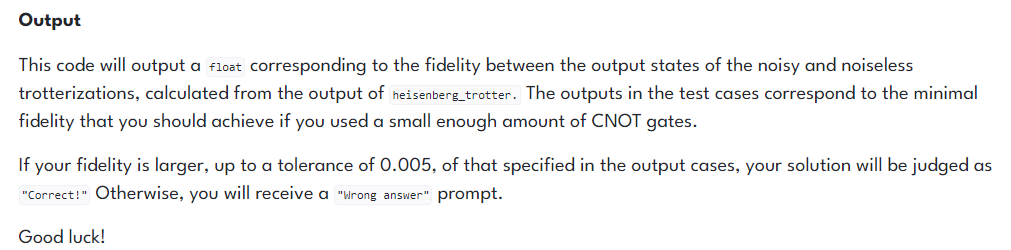

In [114]:
import json
import pennylane as qml
import pennylane.numpy as np

num_wires = 4
dev = qml.device("default.mixed", wires=num_wires)

@qml.qnode(dev)
def heisenberg_trotter(couplings, p, time, depth):
    """This QNode returns the final state of the spin chain after evolution for a time t, 
    under the Trotter approximation of the exponential of the Heisenberg Hamiltonian.
    
    Args:
        couplings (list(float)): 
            An array of length 4 that contains the coupling constants and the magnetic field 
            strength, in the order [J_x, J_y, J_z, h].
        p (float): The depolarization probability after each CNOT gate.
        depth (int): The Trotterization depth.
        time (float): Time during which the state evolves

    Returns:
        (numpy.tensor): The evolved quantum state.
    """
    
    # https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html
    #######################################
    #  (-0.9143891828606319) [X2]
    #+ (-0.9143891828606319) [X1]
    #+ (-0.9143891828606319) [X0]
    #+ (-0.9143891828606319) [X3]
    #+ (-2.0058890512703593) [X3 X0]
    #+ (-2.0058890512703593) [X2 X3]
    #+ (-2.0058890512703593) [X1 X2]
    #+ (-2.0058890512703593) [X0 X1]
    #+ (-2.0052832468022497) [Z3 Z0]
    #+ (-2.0052832468022497) [Z2 Z3]
    #+ (-2.0052832468022497) [Z1 Z2]
    #+ (-2.0052832468022497) [Z0 Z1]
    #+ (-1.2728052538194878) [Y3 Y0]
    #+ (-1.2728052538194878) [Y2 Y3]
    #+ (-1.2728052538194878) [Y1 Y2]
    #+ (-1.2728052538194878) [Y0 Y1]
    #######################################
    #──╭RXX(-1.77)─────────────────────────╭RXX(-1.77)─╭RYY(-1.24)─────────────────────────╭RYY(-1.24)
    #──│───────────────────────╭RXX(-1.77)─╰RXX(-1.77)─│───────────────────────╭RYY(-1.24)─╰RYY(-1.24)
    #──│───────────╭RXX(-1.77)─╰RXX(-1.77)─────────────│───────────╭RYY(-1.24)─╰RYY(-1.24)────────────
    #──╰RXX(-1.77)─╰RXX(-1.77)─────────────────────────╰RYY(-1.24)─╰RYY(-1.24)────────────────────────

    #──╭RZZ(-1.38)─────────────────────────╭RZZ(-1.38)──RX(-2.04)─╭RXX(-1.77)────────────────────────
    #──│───────────────────────╭RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─│───────────────────────╭RXX(-1.77)
    #──│───────────╭RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─────────────│───────────╭RXX(-1.77)─╰RXX(-1.77)
    #──╰RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─────────────────────────╰RXX(-1.77)─╰RXX(-1.77)────────────

    #──╭RXX(-1.77)─╭RYY(-1.24)─────────────────────────╭RYY(-1.24)─╭RZZ(-1.38)────────────────────────
    #──╰RXX(-1.77)─│───────────────────────╭RYY(-1.24)─╰RYY(-1.24)─│───────────────────────╭RZZ(-1.38)
    #──────────────│───────────╭RYY(-1.24)─╰RYY(-1.24)─────────────│───────────╭RZZ(-1.38)─╰RZZ(-1.38)
    #──────────────╰RYY(-1.24)─╰RYY(-1.24)─────────────────────────╰RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─

    #──╭RZZ(-1.38)──RX(-2.04)─┤  State
    #──╰RZZ(-1.38)──RX(-2.04)─┤  State
    #───RX(-2.04)─────────────┤  State
    #─────────────────────────┤  State
    #######################################
    '''
    q_0: ┤ Ry(π/2) ├┤ Rx(π) ├──■──────────────■──────────────────────────────────»
         ├─────────┤├───────┤  │              │                                  »
    q_1: ┤ Ry(π/2) ├┤ Rx(π) ├──┼──────────────┼───────────────────────────■──────»
         ├─────────┤├───────┤  │              │                         ┌─┴─┐    »
    q_2: ┤ Ry(π/2) ├┤ Rx(π) ├──┼──────────────┼────■──────────────■─────┤ X ├────»
         ├─────────┤├───────┤┌─┴─┐┌────────┐┌─┴─┐┌─┴─┐┌────────┐┌─┴─┐┌──┴───┴───┐»
    q_3: ┤ Ry(π/2) ├┤ Rx(π) ├┤ X ├┤ Rz(-1) ├┤ X ├┤ X ├┤ Rz(-1) ├┤ X ├┤ Rz(-π/2) ├»
         └─────────┘└───────┘└───┘└────────┘└───┘└───┘└────────┘└───┘└──────────┘»
    «                                                 ┌──────────┐┌─────────┐     »
    «q_0: ─────────────────────■───────────────────■──┤ Rz(-π/2) ├┤ Ry(π/2) ├──■──»
    «                        ┌─┴─┐     ┌────────┐┌─┴─┐├──────────┤├─────────┤  │  »
    «q_1: ─────────────■─────┤ X ├─────┤ Rz(-1) ├┤ X ├┤ Rz(-π/2) ├┤ Ry(π/2) ├──┼──»
    «      ┌────────┐┌─┴─┐┌──┴───┴───┐┌┴────────┤└───┘└──────────┘└─────────┘  │  »
    «q_2: ─┤ Rz(-1) ├┤ X ├┤ Rz(-π/2) ├┤ Ry(π/2) ├──────────────────────────────┼──»
    «     ┌┴────────┤└───┘└──────────┘└─────────┘                            ┌─┴─┐»
    «q_3: ┤ Ry(π/2) ├────────────────────────────────────────────────────────┤ X ├»
    «     └─────────┘                                                        └───┘»
    «                                                                   »
    «q_0: ────────────■─────────────────────────────────────────────────»
    «                 │                                                 »
    «q_1: ────────────┼───────────────────────────■──────────────────■──»
    «                 │                         ┌─┴─┐    ┌────────┐┌─┴─┐»
    «q_2: ────────────┼────■──────────────■─────┤ X ├────┤ Rz(-2) ├┤ X ├»
    «     ┌────────┐┌─┴─┐┌─┴─┐┌────────┐┌─┴─┐┌──┴───┴───┐└────────┘└───┘»
    «q_3: ┤ Rz(-2) ├┤ X ├┤ X ├┤ Rz(-2) ├┤ X ├┤ Rx(-π/2) ├───────────────»
    «     └────────┘└───┘└───┘└────────┘└───┘└──────────┘               »
    «                                ┌──────────┐                         »
    «q_0: ─────■──────────────────■──┤ Rx(-π/2) ├──■──────────────■───────»
    «        ┌─┴─┐    ┌────────┐┌─┴─┐├──────────┤  │              │       »
    «q_1: ───┤ X ├────┤ Rz(-2) ├┤ X ├┤ Rx(-π/2) ├──┼──────────────┼───────»
    «     ┌──┴───┴───┐└────────┘└───┘└──────────┘  │              │       »
    «q_2: ┤ Rx(-π/2) ├─────────────────────────────┼──────────────┼────■──»
    «     └──────────┘                           ┌─┴─┐┌────────┐┌─┴─┐┌─┴─┐»
    «q_3: ───────────────────────────────────────┤ X ├┤ Rz(-1) ├┤ X ├┤ X ├»
    «                                            └───┘└────────┘└───┘└───┘»
    «                                                                          »
    «q_0: ───────────────────────────────────────────────■──────────────────■──»
    «                                                  ┌─┴─┐    ┌────────┐┌─┴─┐»
    «q_1: ────────────────────■──────────────────■─────┤ X ├────┤ Rz(-1) ├┤ X ├»
    «                       ┌─┴─┐    ┌────────┐┌─┴─┐┌──┴───┴───┐└────────┘└───┘»
    «q_2: ────────────■─────┤ X ├────┤ Rz(-1) ├┤ X ├┤ Rx(-0.3) ├───────────────»
    «     ┌────────┐┌─┴─┐┌──┴───┴───┐└────────┘└───┘└──────────┘               »
    «q_3: ┤ Rz(-1) ├┤ X ├┤ Rx(-0.3) ├──────────────────────────────────────────»
    «     └────────┘└───┘└──────────┘                                          »
    «     ┌──────────┐
    «q_0: ┤ Rx(-0.3) ├
    «     ├──────────┤
    «q_1: ┤ Rx(-0.3) ├
    «     └──────────┘
    «q_2: ────────────
    «                 
    «q_3: ────────────
    «                 
    '''
    
    ### coeff = coupling * time * (2/steps)
    
    def CNOT_N(w1,w2,p):
        qml.CNOT(wires=[w1,w2])
        qml.DepolarizingChannel(p, wires=[w2])
    
    
    def hamiltonian_create(couplings, p):
        
        qml.RY(np.pi/2,wires=0)
        qml.RY(np.pi/2,wires=1) 
        qml.RY(np.pi/2,wires=2) 
        qml.RY(np.pi/2,wires=3) 
        qml.RX(np.pi,wires=0)
        qml.RX(np.pi,wires=1) 
        qml.RX(np.pi,wires=2) 
        qml.RX(np.pi,wires=3) 
    
        qml.CNOT(wires=[3,0])
        qml.DepolarizingChannel(p, wires=0)
        qml.RX(couplings[0],wires=0)
        qml.CNOT(wires=[3,0])
        qml.DepolarizingChannel(p, wires=0)
        qml.CNOT(wires=[2,3])
        qml.DepolarizingChannel(p, wires=3)
        qml.RX(couplings[0],wires=3)
        qml.CNOT(wires=[2,3])
        qml.DepolarizingChannel(p, wires=3)
        qml.CNOT(wires=[1,2])
        qml.DepolarizingChannel(p, wires=2)
        qml.RX(couplings[0],wires=2)
        qml.CNOT(wires=[1,2])
        qml.DepolarizingChannel(p, wires=2)
        qml.CNOT(wires=[0,1])
        qml.DepolarizingChannel(p, wires=1)
        qml.RX(couplings[0],wires=1)
        qml.CNOT(wires=[0,1])
        qml.DepolarizingChannel(p, wires=1)
        
        qml.RX(-np.pi/2,wires=0)
        qml.RX(-np.pi/2,wires=1) 
        qml.RX(-np.pi/2,wires=2) 
        qml.RX(-np.pi/2,wires=3)
        qml.RY(np.pi/2,wires=0)
        qml.RY(np.pi/2,wires=1) 
        qml.RY(np.pi/2,wires=2) 
        qml.RY(np.pi/2,wires=3)
        
        qml.CNOT(wires=[3,0])
        qml.DepolarizingChannel(p, wires=0)
        qml.RZ(couplings[1],wires=0)
        qml.CNOT(wires=[3,0])
        qml.DepolarizingChannel(p, wires=0)
        qml.CNOT(wires=[2,3])
        qml.DepolarizingChannel(p, wires=3)
        qml.RZ(couplings[1],wires=3)
        qml.CNOT(wires=[2,3])
        qml.DepolarizingChannel(p, wires=3)
        qml.CNOT(wires=[1,2])
        qml.DepolarizingChannel(p, wires=2)
        qml.RZ(couplings[1],wires=2)
        qml.CNOT(wires=[1,2])
        qml.DepolarizingChannel(p, wires=2)
        qml.CNOT(wires=[0,1])
        qml.DepolarizingChannel(p, wires=1)
        qml.RZ(couplings[1],wires=1)
        qml.CNOT(wires=[0,1])
        qml.DepolarizingChannel(p, wires=1)
        
        qml.RX(-np.pi/2,wires=0)
        qml.RX(-np.pi/2,wires=1) 
        qml.RX(-np.pi/2,wires=2) 
        qml.RX(-np.pi/2,wires=3)
        
        qml.CNOT(wires=[3,0])
        qml.DepolarizingChannel(p, wires=0)
        qml.RZ(couplings[2],wires=0)
        qml.CNOT(wires=[3,0])
        qml.DepolarizingChannel(p, wires=0)
        qml.CNOT(wires=[2,3])
        qml.DepolarizingChannel(p, wires=3)
        qml.RZ(couplings[2],wires=3)
        qml.CNOT(wires=[2,3])
        qml.DepolarizingChannel(p, wires=3)
        qml.CNOT(wires=[1,2])
        qml.DepolarizingChannel(p, wires=2)
        qml.RZ(couplings[2],wires=2)
        qml.CNOT(wires=[1,2])
        qml.DepolarizingChannel(p, wires=2)
        qml.CNOT(wires=[0,1])
        qml.DepolarizingChannel(p, wires=1)
        qml.RZ(couplings[2],wires=1)
        qml.CNOT(wires=[0,1])
        qml.DepolarizingChannel(p, wires=1)
        
        qml.RX(couplings[3],wires=0)
        qml.RX(couplings[3],wires=1) 
        qml.RX(couplings[3],wires=2) 
        qml.RX(couplings[3],wires=3)
        

    # Put your code here #
    #coeffs = couplings * time * (2/depth)
    coeffs = []
    for i in couplings:
        coeffs.append(-i * time * (2/depth))
    #print(f"couplings: {couplings}\ncoeffs: {coeffs}")
    
    for i in range(depth):
        hamiltonian_create(coeffs, p)
    
    return qml.state()


def calculate_fidelity(couplings, p, time, depth):
    """This function returns the fidelity between the final states of the noisy and
    noiseless Trotterizations of the Heisenberg models, using only CNOT and rotation gates

    Args:
        couplings (list(float)): 
            A list with the J_x, J_y, J_z and h parameters in the Heisenberg Hamiltonian, as
            defined in the problem statement.
        p (float): The depolarization probability of the depolarization gate that acts on the
                   target qubit of each CNOT gate.
        time (float): The period of time evolution simulated by the Trotterization.
        depth (int): The Trotterization depth.

    Returns:
        (float): Fidelity between final states of the noisy and noiseless Trotterizations
    """
    return qml.math.fidelity(heisenberg_trotter(couplings,0,time, depth),heisenberg_trotter(couplings,p,time,depth))


# These functions are responsible for testing the solution.
def run(test_case_input: str) -> str:

    ins = json.loads(test_case_input)
    output =calculate_fidelity(*ins)
    ### Testing
    print(f"fidelity of noise vs. no noise: {output}")
    return str(output)

def check(solution_output: str, expected_output: str) -> None:
    """
    Compare solution with expected.

    Args:
            solution_output: The output from an evaluated solution. Will be
            the same type as returned.
            expected_output: The correct result for the test case.

    Raises: 
            ``AssertionError`` if the solution output is incorrect in any way.
            
    """
    def create_hamiltonian(params):

        couplings = [-params[-1]]
        ops = [qml.PauliX(3)]

        for i in range(3):

            couplings = [-params[-1]] + couplings
            ops = [qml.PauliX(i)] + ops        

        for i in range(4):

            couplings = [-params[-2]] + couplings
            ops = [qml.PauliZ(i)@qml.PauliZ((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[-3]] + couplings
            ops = [qml.PauliY(i)@qml.PauliY((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[0]] + couplings
            ops = [qml.PauliX(i)@qml.PauliX((i+1)%4)] + ops    

        #print(f"couplings: {couplings}\n ops:\n{ops}")
        return qml.Hamiltonian(couplings,ops)

    @qml.qnode(dev)
    def evolve(params, time, depth):

        ##testing
        #test = create_hamiltonian(params)
        #print(f"Hamiltonian:\n{test}")
        qml.ApproxTimeEvolution(create_hamiltonian(params), time, depth)

        return qml.state()
    
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    
    tape = heisenberg_trotter.qtape
    names = [op.name for op in tape.operations]
    
    random_params = np.random.uniform(low = 0.8, high = 3.0, size = (4,) )
    
    #def evolve(params, time, depth):
    
    #print(f"\n=============================\nDEFAULT CIRCUIT\n=============================")
    #print(qml.draw(evolve)(random_params,1,2))
    #print(f"\n=============================\nNOISY CIRCUIT\n=============================")
    #print(qml.draw(heisenberg_trotter)(random_params,0,1,2))
    
    
    #assert qml.math.fidelity(heisenberg_trotter(random_params,0,1,2),evolve(random_params,1,2)) >= 1, "Your circuit does not Trotterize the Heisenberg Model"
    test_fid = qml.math.fidelity(heisenberg_trotter(random_params,0,1,2),evolve(random_params,1,2))
    print(f"fidelity: {test_fid}")
          
    assert names.count('ApproxTimeEvolution') == 0, "Your circuit must not use the built-in PennyLane Trotterization"
     
    assert set(names) == {'DepolarizingChannel', 'RX', 'RY', 'RZ', 'CNOT'}, "Your circuit must only use RX, RY, RZ, CNOT, and depolarizing gates (don't use qml.Rot or Paulis)"
    
    print(f"solution_output: {solution_output}")
    print(f"expected_output: {expected_output}")
    assert solution_output >= expected_output-0.005, "Your fidelity is not high enough. You may be using more CNOT gates than needed"


test_cases = [['[[1,2,1,0.3],0.05,2.5,1]', '0.33723981123369573'], ['[[1,3,2,0.3],0.05,2.5,2]', '0.15411351752086694']]

for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[[1,2,1,0.3],0.05,2.5,1]'...
fidelity of noise vs. no noise: 0.40648002098179203
fidelity: 0.04819219863289628
solution_output: 0.40648002098179203
expected_output: 0.33723981123369573
Correct!
Running test case 1 with input '[[1,3,2,0.3],0.05,2.5,2]'...
fidelity of noise vs. no noise: 0.1599382559715975
fidelity: 0.019734532304581522
solution_output: 0.1599382559715975
expected_output: 0.15411351752086694
Correct!


* Testing With Default Libraries

In [57]:
import json
import pennylane as qml
import pennylane.numpy as np

num_wires = 4
dev = qml.device("default.mixed", wires=num_wires)

@qml.qnode(dev)
def heisenberg_trotter(couplings, p, time, depth):
    """This QNode returns the final state of the spin chain after evolution for a time t, 
    under the Trotter approximation of the exponential of the Heisenberg Hamiltonian.
    
    Args:
        couplings (list(float)): 
            An array of length 4 that contains the coupling constants and the magnetic field 
            strength, in the order [J_x, J_y, J_z, h].
        p (float): The depolarization probability after each CNOT gate.
        depth (int): The Trotterization depth.
        time (float): Time during which the state evolves

    Returns:
        (numpy.tensor): The evolved quantum state.
    """
    def create_hamiltonian(params):

        couplings = [-params[-1]]
        ops = [qml.PauliX(3)]

        for i in range(3):

            couplings = [-params[-1]] + couplings
            ops = [qml.PauliX(i)] + ops        

        for i in range(4):

            couplings = [-params[-2]] + couplings
            ops = [qml.PauliZ(i)@qml.PauliZ((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[-3]] + couplings
            ops = [qml.PauliY(i)@qml.PauliY((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[0]] + couplings
            ops = [qml.PauliX(i)@qml.PauliX((i+1)%4)] + ops    

        return qml.Hamiltonian(couplings,ops)

    
    ### coeff = coupling * time * (2/steps)

    qml.ApproxTimeEvolution(create_hamiltonian(couplings), time, depth)
    
    return qml.state()


def calculate_fidelity(couplings, p, time, depth):
    """This function returns the fidelity between the final states of the noisy and
    noiseless Trotterizations of the Heisenberg models, using only CNOT and rotation gates

    Args:
        couplings (list(float)): 
            A list with the J_x, J_y, J_z and h parameters in the Heisenberg Hamiltonian, as
            defined in the problem statement.
        p (float): The depolarization probability of the depolarization gate that acts on the
                   target qubit of each CNOT gate.
        time (float): The period of time evolution simulated by the Trotterization.
        depth (int): The Trotterization depth.

    Returns:
        (float): Fidelity between final states of the noisy and noiseless Trotterizations
    """
    return qml.math.fidelity(heisenberg_trotter(couplings,0,time, depth),heisenberg_trotter(couplings,p,time,depth))


# These functions are responsible for testing the solution.
def run(test_case_input: str) -> str:

    ins = json.loads(test_case_input)
    output =calculate_fidelity(*ins)
    ### Testing
    print(f"fidelity of noise vs. no noise: {output}")
    return str(output)

def check(solution_output: str, expected_output: str) -> None:
    """
    Compare solution with expected.

    Args:
            solution_output: The output from an evaluated solution. Will be
            the same type as returned.
            expected_output: The correct result for the test case.

    Raises: 
            ``AssertionError`` if the solution output is incorrect in any way.
            
    """
    def create_hamiltonian(params):

        couplings = [-params[-1]]
        ops = [qml.PauliX(3)]

        for i in range(3):

            couplings = [-params[-1]] + couplings
            ops = [qml.PauliX(i)] + ops        

        for i in range(4):

            couplings = [-params[-2]] + couplings
            ops = [qml.PauliZ(i)@qml.PauliZ((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[-3]] + couplings
            ops = [qml.PauliY(i)@qml.PauliY((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[0]] + couplings
            ops = [qml.PauliX(i)@qml.PauliX((i+1)%4)] + ops    

        #print(f"couplings: {couplings}\n ops:\n{ops}")
        return qml.Hamiltonian(couplings,ops)

    @qml.qnode(dev)
    def evolve(params, time, depth):

        qml.ApproxTimeEvolution(create_hamiltonian(params), time, depth)#.decomposition()

        return qml.state()
    
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    
    tape = heisenberg_trotter.qtape
    names = [op.name for op in tape.operations]
    
    random_params = np.random.uniform(low = 0.8, high = 3.0, size = (4,) )
    
    #def evolve(params, time, depth):
    '''
    print(f"\n=============================\nDEFAULT CIRCUIT\n=============================")
    print(qml.draw(evolve)(random_params,1,2))
    print(f"\n=============================\nNOISY CIRCUIT\n=============================")
    print(qml.draw(heisenberg_trotter)(random_params,0,1,2))
    '''
    #assert qml.math.fidelity(heisenberg_trotter(random_params,0,1,2),evolve(random_params,1,2)) >= 1, "Your circuit does not Trotterize the Heisenberg Model"
    test_fid = qml.math.fidelity(heisenberg_trotter(random_params,0,1,2),evolve(random_params,1,2))
    print(f"fidelity: {test_fid}")
          
    assert names.count('ApproxTimeEvolution') == 0, "Your circuit must not use the built-in PennyLane Trotterization"
     
    assert set(names) == {'DepolarizingChannel', 'RX', 'RY', 'RZ', 'CNOT'}, "Your circuit must only use RX, RY, RZ, CNOT, and depolarizing gates (don't use qml.Rot or Paulis)"
    
    print(f"solution_output: {solution_output}")
    print(f"expected_output: {expected_output}")
    assert solution_output >= expected_output-0.005, "Your fidelity is not high enough. You may be using more CNOT gates than needed"


test_cases = [['[[1,2,1,0.3],0.05,2.5,1]', '0.33723981123369573'], ['[[1,3,2,0.3],0.05,2.5,2]', '0.15411351752086694']]

for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[[1,2,1,0.3],0.05,2.5,1]'...
fidelity of noise vs. no noise: 1.0000000776703117
fidelity: 1.0000000744764943


AssertionError: Your circuit must not use the built-in PennyLane Trotterization

* Printing cell

In [111]:
def create_hamiltonian(params):

    couplings = [-params[-1]]
    ops = [qml.PauliX(3)]

    for i in range(3):

        couplings = [-params[-1]] + couplings
        ops = [qml.PauliX(i)] + ops        

    for i in range(4):

        couplings = [-params[-2]] + couplings
        ops = [qml.PauliZ(i)@qml.PauliZ((i+1)%4)] + ops

    for i in range(4):

        couplings = [-params[-3]] + couplings
        ops = [qml.PauliY(i)@qml.PauliY((i+1)%4)] + ops

    for i in range(4):

        couplings = [-params[0]] + couplings
        ops = [qml.PauliX(i)@qml.PauliX((i+1)%4)] + ops    

    return qml.Hamiltonian(couplings,ops)

    
    ### coeff = coupling * time * (2/steps)

    qml.ApproxTimeEvolution(create_hamiltonian(couplings), time, depth)
    
    return qml.state()

@qml.qnode(dev)
def evolve(params, time, depth):

    test = qml.ApproxTimeEvolution(create_hamiltonian(params), time, depth).expand()
    print(test.circuit)
    return qml.state()
#print(qml.draw(heisenberg_trotter)([1,2,1,0.3],0,1,2))
test = evolve([1,2,1,0.3],1,2)
#print(test)
#print(qml.draw(evolve)([1,2,1,0.3],1,2))
#list(test)

[PauliRot(-1.0, XX, wires=[3, 0]), PauliRot(-1.0, XX, wires=[2, 3]), PauliRot(-1.0, XX, wires=[1, 2]), PauliRot(-1.0, XX, wires=[0, 1]), PauliRot(-2.0, YY, wires=[3, 0]), PauliRot(-2.0, YY, wires=[2, 3]), PauliRot(-2.0, YY, wires=[1, 2]), PauliRot(-2.0, YY, wires=[0, 1]), PauliRot(-1.0, ZZ, wires=[3, 0]), PauliRot(-1.0, ZZ, wires=[2, 3]), PauliRot(-1.0, ZZ, wires=[1, 2]), PauliRot(-1.0, ZZ, wires=[0, 1]), PauliRot(-0.3, X, wires=[2]), PauliRot(-0.3, X, wires=[1]), PauliRot(-0.3, X, wires=[0]), PauliRot(-0.3, X, wires=[3]), PauliRot(-1.0, XX, wires=[3, 0]), PauliRot(-1.0, XX, wires=[2, 3]), PauliRot(-1.0, XX, wires=[1, 2]), PauliRot(-1.0, XX, wires=[0, 1]), PauliRot(-2.0, YY, wires=[3, 0]), PauliRot(-2.0, YY, wires=[2, 3]), PauliRot(-2.0, YY, wires=[1, 2]), PauliRot(-2.0, YY, wires=[0, 1]), PauliRot(-1.0, ZZ, wires=[3, 0]), PauliRot(-1.0, ZZ, wires=[2, 3]), PauliRot(-1.0, ZZ, wires=[1, 2]), PauliRot(-1.0, ZZ, wires=[0, 1]), PauliRot(-0.3, X, wires=[2]), PauliRot(-0.3, X, wires=[1]), Pau

In [39]:
import json
import pennylane as qml
import pennylane.numpy as np

num_wires = 4
dev = qml.device("default.mixed", wires=num_wires)

@qml.qnode(dev)
def heisenberg_trotter(couplings, p, time, depth):
    """This QNode returns the final state of the spin chain after evolution for a time t, 
    under the Trotter approximation of the exponential of the Heisenberg Hamiltonian.
    
    Args:
        couplings (list(float)): 
            An array of length 4 that contains the coupling constants and the magnetic field 
            strength, in the order [J_x, J_y, J_z, h].
        p (float): The depolarization probability after each CNOT gate.
        depth (int): The Trotterization depth.
        time (float): Time during which the state evolves

    Returns:
        (numpy.tensor): The evolved quantum state.
    """
    
    # https://docs.pennylane.ai/en/stable/code/api/pennylane.ApproxTimeEvolution.html
    #######################################
    #  (-0.9143891828606319) [X2]
    #+ (-0.9143891828606319) [X1]
    #+ (-0.9143891828606319) [X0]
    #+ (-0.9143891828606319) [X3]
    #+ (-2.0058890512703593) [X3 X0]
    #+ (-2.0058890512703593) [X2 X3]
    #+ (-2.0058890512703593) [X1 X2]
    #+ (-2.0058890512703593) [X0 X1]
    #+ (-2.0052832468022497) [Z3 Z0]
    #+ (-2.0052832468022497) [Z2 Z3]
    #+ (-2.0052832468022497) [Z1 Z2]
    #+ (-2.0052832468022497) [Z0 Z1]
    #+ (-1.2728052538194878) [Y3 Y0]
    #+ (-1.2728052538194878) [Y2 Y3]
    #+ (-1.2728052538194878) [Y1 Y2]
    #+ (-1.2728052538194878) [Y0 Y1]
    #######################################
    #──╭RXX(-1.77)─────────────────────────╭RXX(-1.77)─╭RYY(-1.24)─────────────────────────╭RYY(-1.24)
    #──│───────────────────────╭RXX(-1.77)─╰RXX(-1.77)─│───────────────────────╭RYY(-1.24)─╰RYY(-1.24)
    #──│───────────╭RXX(-1.77)─╰RXX(-1.77)─────────────│───────────╭RYY(-1.24)─╰RYY(-1.24)────────────
    #──╰RXX(-1.77)─╰RXX(-1.77)─────────────────────────╰RYY(-1.24)─╰RYY(-1.24)────────────────────────

    #──╭RZZ(-1.38)─────────────────────────╭RZZ(-1.38)──RX(-2.04)─╭RXX(-1.77)────────────────────────
    #──│───────────────────────╭RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─│───────────────────────╭RXX(-1.77)
    #──│───────────╭RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─────────────│───────────╭RXX(-1.77)─╰RXX(-1.77)
    #──╰RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─────────────────────────╰RXX(-1.77)─╰RXX(-1.77)────────────

    #──╭RXX(-1.77)─╭RYY(-1.24)─────────────────────────╭RYY(-1.24)─╭RZZ(-1.38)────────────────────────
    #──╰RXX(-1.77)─│───────────────────────╭RYY(-1.24)─╰RYY(-1.24)─│───────────────────────╭RZZ(-1.38)
    #──────────────│───────────╭RYY(-1.24)─╰RYY(-1.24)─────────────│───────────╭RZZ(-1.38)─╰RZZ(-1.38)
    #──────────────╰RYY(-1.24)─╰RYY(-1.24)─────────────────────────╰RZZ(-1.38)─╰RZZ(-1.38)──RX(-2.04)─

    #──╭RZZ(-1.38)──RX(-2.04)─┤  State
    #──╰RZZ(-1.38)──RX(-2.04)─┤  State
    #───RX(-2.04)─────────────┤  State
    #─────────────────────────┤  State
    #######################################
    '''
    q_0: ┤ Ry(π/2) ├┤ Rx(π) ├──■──────────────■──────────────────────────────────»
         ├─────────┤├───────┤  │              │                                  »
    q_1: ┤ Ry(π/2) ├┤ Rx(π) ├──┼──────────────┼───────────────────────────■──────»
         ├─────────┤├───────┤  │              │                         ┌─┴─┐    »
    q_2: ┤ Ry(π/2) ├┤ Rx(π) ├──┼──────────────┼────■──────────────■─────┤ X ├────»
         ├─────────┤├───────┤┌─┴─┐┌────────┐┌─┴─┐┌─┴─┐┌────────┐┌─┴─┐┌──┴───┴───┐»
    q_3: ┤ Ry(π/2) ├┤ Rx(π) ├┤ X ├┤ Rz(-1) ├┤ X ├┤ X ├┤ Rz(-1) ├┤ X ├┤ Rz(-π/2) ├»
         └─────────┘└───────┘└───┘└────────┘└───┘└───┘└────────┘└───┘└──────────┘»
    «                                                 ┌──────────┐┌─────────┐     »
    «q_0: ─────────────────────■───────────────────■──┤ Rz(-π/2) ├┤ Ry(π/2) ├──■──»
    «                        ┌─┴─┐     ┌────────┐┌─┴─┐├──────────┤├─────────┤  │  »
    «q_1: ─────────────■─────┤ X ├─────┤ Rz(-1) ├┤ X ├┤ Rz(-π/2) ├┤ Ry(π/2) ├──┼──»
    «      ┌────────┐┌─┴─┐┌──┴───┴───┐┌┴────────┤└───┘└──────────┘└─────────┘  │  »
    «q_2: ─┤ Rz(-1) ├┤ X ├┤ Rz(-π/2) ├┤ Ry(π/2) ├──────────────────────────────┼──»
    «     ┌┴────────┤└───┘└──────────┘└─────────┘                            ┌─┴─┐»
    «q_3: ┤ Ry(π/2) ├────────────────────────────────────────────────────────┤ X ├»
    «     └─────────┘                                                        └───┘»
    «                                                                   »
    «q_0: ────────────■─────────────────────────────────────────────────»
    «                 │                                                 »
    «q_1: ────────────┼───────────────────────────■──────────────────■──»
    «                 │                         ┌─┴─┐    ┌────────┐┌─┴─┐»
    «q_2: ────────────┼────■──────────────■─────┤ X ├────┤ Rz(-2) ├┤ X ├»
    «     ┌────────┐┌─┴─┐┌─┴─┐┌────────┐┌─┴─┐┌──┴───┴───┐└────────┘└───┘»
    «q_3: ┤ Rz(-2) ├┤ X ├┤ X ├┤ Rz(-2) ├┤ X ├┤ Rx(-π/2) ├───────────────»
    «     └────────┘└───┘└───┘└────────┘└───┘└──────────┘               »
    «                                ┌──────────┐                         »
    «q_0: ─────■──────────────────■──┤ Rx(-π/2) ├──■──────────────■───────»
    «        ┌─┴─┐    ┌────────┐┌─┴─┐├──────────┤  │              │       »
    «q_1: ───┤ X ├────┤ Rz(-2) ├┤ X ├┤ Rx(-π/2) ├──┼──────────────┼───────»
    «     ┌──┴───┴───┐└────────┘└───┘└──────────┘  │              │       »
    «q_2: ┤ Rx(-π/2) ├─────────────────────────────┼──────────────┼────■──»
    «     └──────────┘                           ┌─┴─┐┌────────┐┌─┴─┐┌─┴─┐»
    «q_3: ───────────────────────────────────────┤ X ├┤ Rz(-1) ├┤ X ├┤ X ├»
    «                                            └───┘└────────┘└───┘└───┘»
    «                                                                          »
    «q_0: ───────────────────────────────────────────────■──────────────────■──»
    «                                                  ┌─┴─┐    ┌────────┐┌─┴─┐»
    «q_1: ────────────────────■──────────────────■─────┤ X ├────┤ Rz(-1) ├┤ X ├»
    «                       ┌─┴─┐    ┌────────┐┌─┴─┐┌──┴───┴───┐└────────┘└───┘»
    «q_2: ────────────■─────┤ X ├────┤ Rz(-1) ├┤ X ├┤ Rx(-0.3) ├───────────────»
    «     ┌────────┐┌─┴─┐┌──┴───┴───┐└────────┘└───┘└──────────┘               »
    «q_3: ┤ Rz(-1) ├┤ X ├┤ Rx(-0.3) ├──────────────────────────────────────────»
    «     └────────┘└───┘└──────────┘                                          »
    «     ┌──────────┐
    «q_0: ┤ Rx(-0.3) ├
    «     ├──────────┤
    «q_1: ┤ Rx(-0.3) ├
    «     └──────────┘
    «q_2: ────────────
    «                 
    «q_3: ────────────
    «                 
    '''
    
    ### coeff = coupling * time * (2/steps)
    
    def CNOT_N(w1,w2,p):
        qml.CNOT(wires=[w1,w2])
        qml.DepolarizingChannel(p, wires=[w2])
    
    
    def hamiltonian_create(couplings, p):
        
        qml.RY(np.pi/2,wires=0)
        qml.RY(np.pi/2,wires=1) 
        qml.RY(np.pi/2,wires=2) 
        qml.RY(np.pi/2,wires=3) 
        qml.RX(np.pi,wires=0)
        qml.RX(np.pi,wires=1) 
        qml.RX(np.pi,wires=2) 
        qml.RX(np.pi,wires=3) 
    
        CNOT_N(0,3,p)
        qml.RX(couplings[0],wires=3)
        CNOT_N(0,3,p)
        CNOT_N(2,3,p)
        qml.RX(couplings[0],wires=3)
        CNOT_N(2,3,p)
        CNOT_N(1,2,p)
        qml.RX(couplings[0],wires=2)
        CNOT_N(1,2,p)
        CNOT_N(0,1,p)
        qml.RX(couplings[0],wires=1)
        CNOT_N(0,1,p)
        
        qml.RZ(-np.pi/2,wires=0)
        qml.RZ(-np.pi/2,wires=1) 
        qml.RZ(-np.pi/2,wires=2) 
        qml.RZ(-np.pi/2,wires=3)
        qml.RY(np.pi/2,wires=0)
        qml.RY(np.pi/2,wires=1) 
        qml.RY(np.pi/2,wires=2) 
        qml.RY(np.pi/2,wires=3)
        
        CNOT_N(0,3,p)
        qml.RZ(couplings[1],wires=3)
        CNOT_N(0,3,p)
        CNOT_N(2,3,p)
        qml.RZ(couplings[1],wires=3)
        CNOT_N(2,3,p)
        CNOT_N(1,2,p)
        qml.RZ(couplings[1],wires=2)
        CNOT_N(1,2,p)
        CNOT_N(0,1,p)
        qml.RZ(couplings[1],wires=1)
        CNOT_N(0,1,p)
        
        qml.RX(-np.pi/2,wires=0)
        qml.RX(-np.pi/2,wires=1) 
        qml.RX(-np.pi/2,wires=2) 
        qml.RX(-np.pi/2,wires=3)
        
        CNOT_N(0,3,p)
        qml.RZ(couplings[2],wires=3)
        CNOT_N(0,3,p)
        CNOT_N(2,3,p)
        qml.RZ(couplings[2],wires=3)
        CNOT_N(2,3,p)
        CNOT_N(1,2,p)
        qml.RZ(couplings[2],wires=2)
        CNOT_N(1,2,p)
        CNOT_N(0,1,p)
        qml.RZ(couplings[2],wires=1)
        CNOT_N(0,1,p)
        
        qml.RX(couplings[3],wires=0)
        qml.RX(couplings[3],wires=1) 
        qml.RX(couplings[3],wires=2) 
        qml.RX(couplings[3],wires=3)
        

    # Put your code here #
    #coeffs = couplings * time * (2/depth)
    coeffs = []
    for i in couplings:
        coeffs.append(i * time * (2/depth))
    #print(f"couplings: {couplings}\ncoeffs: {coeffs}")
    
    for i in range(depth):
        hamiltonian_create(coeffs, p)
    
    return qml.state()


def calculate_fidelity(couplings, p, time, depth):
    """This function returns the fidelity between the final states of the noisy and
    noiseless Trotterizations of the Heisenberg models, using only CNOT and rotation gates

    Args:
        couplings (list(float)): 
            A list with the J_x, J_y, J_z and h parameters in the Heisenberg Hamiltonian, as
            defined in the problem statement.
        p (float): The depolarization probability of the depolarization gate that acts on the
                   target qubit of each CNOT gate.
        time (float): The period of time evolution simulated by the Trotterization.
        depth (int): The Trotterization depth.

    Returns:
        (float): Fidelity between final states of the noisy and noiseless Trotterizations
    """
    return qml.math.fidelity(heisenberg_trotter(couplings,0,time, depth),heisenberg_trotter(couplings,p,time,depth))


# These functions are responsible for testing the solution.
def run(test_case_input: str) -> str:

    ins = json.loads(test_case_input)
    output =calculate_fidelity(*ins)
    ### Testing
    print(f"fidelity of noise vs. no noise: {output}")
    return str(output)

def check(solution_output: str, expected_output: str) -> None:
    """
    Compare solution with expected.

    Args:
            solution_output: The output from an evaluated solution. Will be
            the same type as returned.
            expected_output: The correct result for the test case.

    Raises: 
            ``AssertionError`` if the solution output is incorrect in any way.
            
    """
    def create_hamiltonian(params):

        couplings = [-params[-1]]
        ops = [qml.PauliX(3)]

        for i in range(3):

            couplings = [-params[-1]] + couplings
            ops = [qml.PauliX(i)] + ops        

        for i in range(4):

            couplings = [-params[-2]] + couplings
            ops = [qml.PauliZ(i)@qml.PauliZ((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[-3]] + couplings
            ops = [qml.PauliY(i)@qml.PauliY((i+1)%4)] + ops

        for i in range(4):

            couplings = [-params[0]] + couplings
            ops = [qml.PauliX(i)@qml.PauliX((i+1)%4)] + ops    

        #print(f"couplings: {couplings}\n ops:\n{ops}")
        return qml.Hamiltonian(couplings,ops)

    @qml.qnode(dev)
    def evolve(params, time, depth):

        ##testing
        #test = create_hamiltonian(params)
        #print(f"Hamiltonian:\n{test}")
        qml.ApproxTimeEvolution(create_hamiltonian(params), time, depth).decomposition()

        return qml.state()
    
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    
    tape = heisenberg_trotter.qtape
    names = [op.name for op in tape.operations]
    
    random_params = np.random.uniform(low = 0.8, high = 3.0, size = (4,) )
    
    #def evolve(params, time, depth):
    
    print(f"\n=============================\nDEFAULT CIRCUIT\n=============================")
    print(qml.draw(evolve)([1,2,1,0.3],2.5,1))
    print(f"\n=============================\nNOISY CIRCUIT\n=============================")
    print(qml.draw(heisenberg_trotter)([1,2,1,0.3],0.05,2.5,1))
    
    #assert qml.math.fidelity(heisenberg_trotter(random_params,0,1,2),evolve(random_params,1,2)) >= 1, "Your circuit does not Trotterize the Heisenberg Model"
    test_fid = qml.math.fidelity(heisenberg_trotter(random_params,0,1,2),evolve(random_params,1,2))
    print(f"fidelity: {test_fid}")
          
    assert names.count('ApproxTimeEvolution') == 0, "Your circuit must not use the built-in PennyLane Trotterization"
     
    assert set(names) == {'DepolarizingChannel', 'RX', 'RY', 'RZ', 'CNOT'}, "Your circuit must only use RX, RY, RZ, CNOT, and depolarizing gates (don't use qml.Rot or Paulis)"
    
    print(f"solution_output: {solution_output}")
    print(f"expected_output: {expected_output}")
    assert solution_output >= expected_output-0.005, "Your fidelity is not high enough. You may be using more CNOT gates than needed"


test_cases = [['[[1,2,1,0.3],0.05,2.5,1]', '0.33723981123369573'], ['[[1,3,2,0.3],0.05,2.5,2]', '0.15411351752086694']]

for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[[1,2,1,0.3],0.05,2.5,1]'...
fidelity of noise vs. no noise: 0.401567974105731

DEFAULT CIRCUIT
0: 
1: 
2: 
3: 

──╭ApproxTimeEvolution(-1.00,-1.00,-1.00,-1.00,-2.00,-2.00,-2.00,-2.00,-1.00,-1.00,-1.00,-1.00,-0.30,-0.30,-0.30,-0.30,2.50)
──├ApproxTimeEvolution(-1.00,-1.00,-1.00,-1.00,-2.00,-2.00,-2.00,-2.00,-1.00,-1.00,-1.00,-1.00,-0.30,-0.30,-0.30,-0.30,2.50)
──├ApproxTimeEvolution(-1.00,-1.00,-1.00,-1.00,-2.00,-2.00,-2.00,-2.00,-1.00,-1.00,-1.00,-1.00,-0.30,-0.30,-0.30,-0.30,2.50)
──╰ApproxTimeEvolution(-1.00,-1.00,-1.00,-1.00,-2.00,-2.00,-2.00,-2.00,-1.00,-1.00,-1.00,-1.00,-0.30,-0.30,-0.30,-0.30,2.50)

──╭RXX(-5.00)─────────────────────────╭RXX(-5.00)─╭RYY(-10.00)──────────────────────────
──│───────────────────────╭RXX(-5.00)─╰RXX(-5.00)─│─────────────────────────╭RYY(-10.00)
──│───────────╭RXX(-5.00)─╰RXX(-5.00)─────────────│────────────╭RYY(-10.00)─╰RYY(-10.00)
──╰RXX(-5.00)─╰RXX(-5.00)─────────────────────────╰RYY(-10.00)─╰RYY(-10.00)────────────

AssertionError: Your fidelity is not high enough. You may be using more CNOT gates than needed